## A quick guide to inference with photXclus

In [1]:
import sys
sys.path.append("../../scripts/")
import photXclus_params as params
import photXclus
import numpy as np

%matplotlib inline
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False

For this example we will use a one-line example cluster catalogue that in stored in the `pkg_data/` folder, and save any output files to a temporaty directory 

In [2]:
import tempfile
from pathlib import Path

#Create a temp directory for this notebook run
_tmpdir = tempfile.TemporaryDirectory()
params.rootdir = str(Path(_tmpdir.name))


params.cat_filename = photXclus.utils.get_default_cluscat()
params.iclus = 0 #run on line iclus = 0 of the cluster catalogue Table. 

### Data loading

We can start by loading the Legacy Survey DR9 photometric data nedded to run photXclus. 

The `data.Cluster` class takes as input the `photXclus_params` lib, that defines necessary parameters to run the code in the the parameter file in `scritps/photXclus_params.py`. 

The value of a given parameter can be set as for `cat_filename` and `iclus` in the previous cell.  

Data loading happens automatically at the `data.Cluster` instanciation. By default, it will retrieve on [astrodatalab](https://datalab.noirlab.edu/). 

In case you main want to re-run this, without doing a new request to astrodatalab, you can choose to save the data to disk, saving will happen in `{params.rootdir}/data/`

In [3]:
clus = photXclus.data.Cluster(params=params, save_data=True)

Fetching Legacy Survey cluster galaxies from astro-datalab...
Done.


Fetching Legacy Survey control galaxies from astro-datalab...
Done.
Saving cluster and control galaxy catalogues to /var/folders/s9/qk_ffsl1741bgtq44m5lfbfm0000gn/T/tmpzlz19z80/data/data_clus0_confirmed.npz


### Now let's run an inference

We can define an `inference.Fit`, that is instanciated with a `data.Cluster` object and the parameter file. 

_Note :  This may take a few seconds the first time around, as instanciation runs numba JIT compilation_

In [4]:
fitter = photXclus.inference.Fit(clus=clus, params=params)

Using mag-z relation file: /Users/fsarron/astro/photXclus/photXclus/pkg_data/mag_star_z.dat


We can now run a MCMC sampling of the posterior

In [5]:
sampler = fitter.run_mcmc()

Initialising ensemble of 68 walkers...


BURN


Sampling progress : 100%|██████████| 250/250 [00:09<00:00, 27.35it/s]
Initialising ensemble of 68 walkers...


SAMPLE


Sampling progress : 100%|██████████| 500/500 [00:33<00:00, 14.88it/s]


We now have posterior samples. 

### If we wish, we can extract point estimate and confidence regions of infered parameters.  

In [6]:
flat_samples = np.vstack(fitter.samples[-200:, :, :])
zlims = (params.zmin, params.zmax)

fitter.clus_properties = photXclus.utils.get_peaks(flat_samples[:, :2], zlims)

It looks like this

In [10]:
fitter.clus_properties

Ngals_clus,z_clus,persistence,zl68_clus,zu68_clus,Ngals_l68_clus,Ngals_u68_clus
float64,float64,float64,float64,float64,float64,float64
15.391740950670364,0.6825000000000001,1.1518475611506878,0.6662015692744997,0.7050903203870629,11.967948924577556,20.503001336323322


### Finally, we can plot some diagnoses for our inference (chains, corner plots, etc.)

Let's start with a corner plot of the cluster model parameters, with detected peak properties annotated

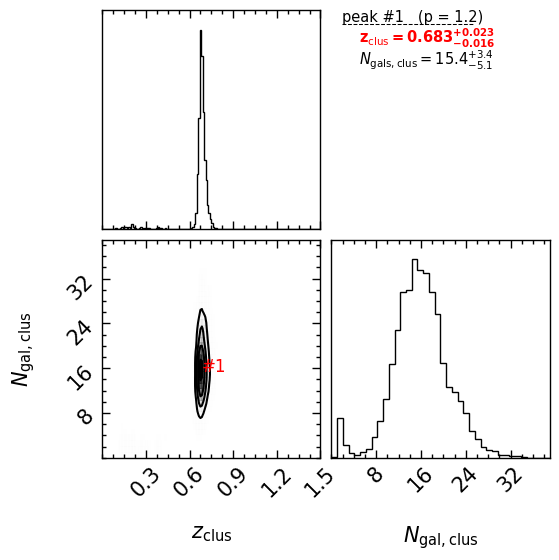

In [7]:
_ = photXclus.plotting.plot_corner(fitter, show=True)

More complete diagnoses can be plotted to a file in `{params.rootdir}/diag/`

In [8]:
_ = photXclus.plotting.diagnosis(clus, fitter)

Diagnosis plot saved to /var/folders/s9/qk_ffsl1741bgtq44m5lfbfm0000gn/T/tmpzlz19z80/diag/diagnosis_clus0_confirmed.png
